In [24]:
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [25]:
data = pd.read_csv("./SMSSpamCollection.csv", sep='\t', header=None)
data


,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [26]:
data.describe()

,0,1
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [27]:
Vocabulary_character = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
                        'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '/', '?', '!', '.', 'α', 'β', 'γ']

In [28]:
def data_preprocessing(sms):
    # convert to lowercase.
    sms = sms.lower()
    # replace all unknown character to 'γ'
    sms = "".join([ c if c in Vocabulary_character else 'γ' for c in sms ])
    # append start ('α') and end ('β') symbols
    sms = 'α' + sms + 'β'
    return sms


In [29]:
total_num_sms = len(data[0])

In [30]:
for i in range(total_num_sms):
    data[1][i] = data_preprocessing(data[1][i])

# determine min and max indices of train data.
train_min_index = 0
train_max_index = int((total_num_sms * 80) / 100)

# determine min and max indices of test data.
test_min_index = train_max_index + 1
test_max_index = total_num_sms


In [31]:
print(data[1][i])

αrofl. its true to its nameβ


In [32]:
# determine number of classes.
num_classes = len(np.unique(data[0]))
print("Number of classes: ", num_classes)


Number of classes:  2


In [33]:
alphabet_count_spam = dict()
alphabet_count_ham = dict()


In [34]:

# count Vocabulary characters in ham and spam training dataset.
def count_trainingset_alphabet_spam_ham():
    # first set items in charecter vocabulary to 0.
    for char in Vocabulary_character:
        alphabet_count_spam[char] = 0
        alphabet_count_ham[char] = 0

    # count each item of charecter vocabulary in training data.
    for i in range(train_min_index, train_max_index):
        sms = data[1][i]
        if data[0][i] == "spam":
            for c in sms:
                alphabet_count_spam[c] = alphabet_count_spam[c] + 1
        else:
            for c in sms:
                alphabet_count_ham[c] = alphabet_count_ham[c] + 1




In [35]:
count_trainingset_alphabet_spam_ham()



In [36]:

bigram_count_spam = dict()
bigram_count_ham = dict()


In [37]:
# count character bigram in ham and spam training dataset.
def count_trainingset_bigram_spam_ham():
    # first set bigram count to 0.
    for first_char in Vocabulary_character:
        for second_char in Vocabulary_character:
            bigram = first_char + second_char
            bigram_count_spam[bigram] = 0
            bigram_count_ham[bigram] = 0

    # count each bigram in training data.
    for i in range(train_min_index, train_max_index):
        sms = data[1][i]
        if data[0][i] == "spam":
            for char in range(len(sms) - 1):
                bigram = sms[char] + sms[char + 1]
                bigram_count_spam[bigram] = bigram_count_spam[bigram] + 1
        else:
            for char in range(len(sms) - 1):
                bigram = sms[char] + sms[char + 1]
                bigram_count_ham[bigram] = bigram_count_ham[bigram] + 1


In [38]:
count_trainingset_bigram_spam_ham()


In [39]:
# taking k as 0.5 for finding prediction.
k = 0.5


In [40]:
prob_bigram_ham = dict()
prob_bigram_spam = dict()


In [41]:
#determine probabilities of bigrams in training dataset.
def prob_bigram_spam_ham():
    for bigram, count in bigram_count_spam.items():
        bigram_first_char = bigram[0]
        prob_bigram_spam[bigram] = (count + k) / (alphabet_count_spam[bigram_first_char] + (k * len(Vocabulary_character)))

    for bigram, count in bigram_count_ham.items():
        bigram_first_char = bigram[0]
        prob_bigram_ham[bigram] = (count + k) / (alphabet_count_ham[bigram_first_char] + (k * len(Vocabulary_character)))


In [42]:
prob_bigram_spam_ham()

In [43]:
# determine log probability of a test SMS message.
# used log to eliminate arithmatic undeflow.
def log_probability(x, spam_ham):
    log_prob = 0
    if spam_ham == "spam":
        for char in range(len(x) - 1):
            bigram = x[char] + x[char + 1]
            log_prob = log_prob + math.log(prob_bigram_spam[bigram])
    else:
        for char in range(len(x) - 1):
            bigram = x[char] + x[char + 1]
            log_prob = log_prob + math.log(prob_bigram_ham[bigram])

    return log_prob


In [44]:
# predict the test SMS message for ham or spam.
def predict(x):
    spam_predict = log_probability(x, "spam")
    ham_predict = log_probability(x, "ham")

    if spam_predict >= ham_predict:
        return "spam"
    else:
        return "ham"


In [45]:
# predict test SMS message in each row in the test dataset.
test_data_count = test_max_index - test_min_index
predicted_classes = np.empty((test_data_count), dtype="<U10")
for n in range(test_min_index, test_max_index):
    index = n - test_min_index
    predicted_classes[index] = predict(data[1][n])

print(test_data_count)    
print("predicted classes of test SMS messages")
print(predicted_classes)
predicted_classes[1]

1114
predicted classes of test SMS messages
['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


'ham'

In [46]:
actual_classes = np.array(data[0])[test_min_index:test_max_index]
print("actual classes of test SMS messages")
print(actual_classes)
actual_classes[0]

actual classes of test SMS messages
['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


'ham'

In [47]:
# determine the confusion matrix.
def confusion_matrix(predicted_classes, actual_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int32)

    for i in range(len(predicted_classes)):
        if predicted_classes[i] == "spam":
            predicted_class = 0
        else:
            predicted_class = 1

        if actual_classes[i] == "spam":
            actual_class = 0
        else:
            actual_class = 1

        cm[predicted_class][actual_class] = cm[predicted_class][actual_class] + 1

    return cm

<function confusion_matrix at 0x7fa27bf4c040>


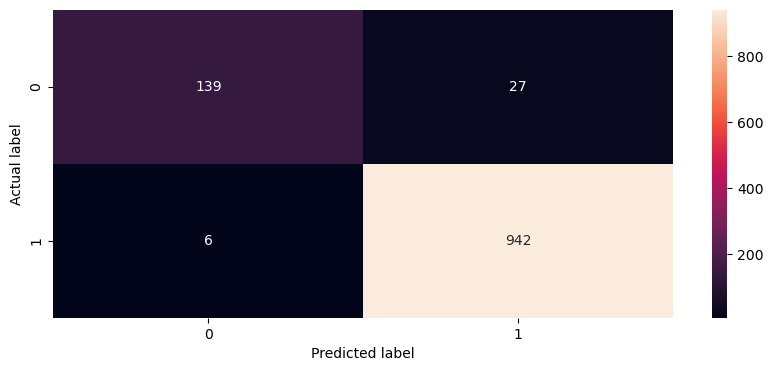

In [48]:
#making confusion matrix using seaborn library
plt.figure(figsize=(10,4))
Confusion_matrix = confusion_matrix(predicted_classes, actual_classes)
ax = sns.heatmap(Confusion_matrix, annot=True, fmt = "d")
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 
print(confusion_matrix)

In [49]:
True_positive = 942
True_negative = 139
False_positive = 27
False_negative = 6

In [50]:
recall = True_positive/(True_positive + False_negative)
recall

0.9936708860759493

In [51]:
Precision = True_positive/(True_positive + False_positive)
Precision


0.9721362229102167

In [52]:
# harmonic mean of the precision and recall
F1_score = (Precision * recall / (Precision + recall)) * 2
F1_score


0.9827856025039122

In [53]:
np.diag(Confusion_matrix) # diagnol element for the confusion matrix

array([139, 942], dtype=int32)

In [54]:
Confusion_matrix.sum().sum() # total sum of testing sms

1114

In [55]:
accuracy = np.diag(Confusion_matrix).sum()/Confusion_matrix.sum().sum()
accuracy
# overoll accuracy from confusion matrix

0.9703770197486535

In [56]:
# predict spam or ham for following sms:
spam_msg = "This is the 2nd time we have tried 2 contact u "
ham_msg = "Will ü b going to esplanade fr home?"


In [57]:

# predict if spam message is predicted to be spam
pre_processd_sms = data_preprocessing(spam_msg)
prediction = predict(pre_processd_sms)
print("message: \"", spam_msg, "\" is : ", prediction)


message: " This is the 2nd time we have tried 2 contact u  " is :  ham


In [58]:
# predict if ham message is predicted to be ham
pre_processd_sms = data_preprocessing(ham_msg)
prediction = predict(pre_processd_sms)
print("message: \"", ham_msg, "\" is : ", prediction)


message: " Will ü b going to esplanade fr home? " is :  ham


'αwill γ b going to esplanade fr home?β'